In [3]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import numpy as np
import networkx as nx

import qiskit
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_optimization.problems import QuadraticProgram

In [4]:
from qiskit import IBMQ
IBMQ.save_account('25b435f4d753c1f8e8538792005520ca5be6560f6136d149e16a9743b9c2904659dcfca6e69f6b9d345477f93214bbed76408a3c6eb32a01b0bbb70739a5fda2')

configrc.store_credentials:WARNING:2022-03-31 15:58:59,902: Credentials already present. Set overwrite=True to overwrite.


In [5]:
provider = IBMQ.load_account()
backend = provider.get_backend('simulator_mps')

In [6]:
provider.backends()

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [7]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

distance
 [[ 0. 48. 91. 33.]
 [48.  0. 63. 71.]
 [91. 63.  0. 92.]
 [33. 71. 92.  0.]]


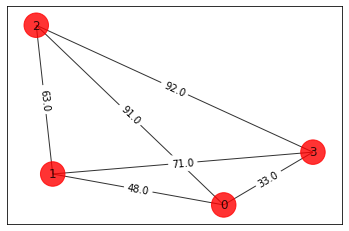

In [8]:
n = 4
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=123)
adj_matrix = nx.to_numpy_matrix(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

order = (0, 1, 2, 3) Distance = 236.0
Best order from brute force = (0, 1, 2, 3) with total distance = 236.0


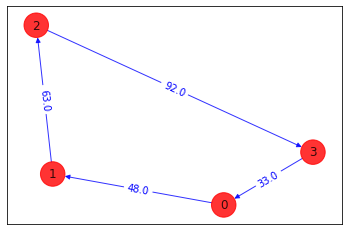

In [9]:
from itertools import permutations


def brute_force_tsp(w, N):
    a = list(permutations(range(1, N)))
    last_best_distance = 1e10
    for i in a:
        distance = 0
        pre_j = 0
        for j in i:
            distance = distance + w[j, pre_j]
            pre_j = j
        distance = distance + w[pre_j, 0]
        order = (0,) + i
        if distance < last_best_distance:
            best_order = order
            last_best_distance = distance
            print("order = " + str(order) + " Distance = " + str(distance))
    return last_best_distance, best_order


best_distance, best_order = brute_force_tsp(adj_matrix, n)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)


draw_tsp_solution(tsp.graph, best_order, colors, pos)

In [10]:
qp = tsp.to_quadratic_program()
print(qp.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: TSP

Minimize
 obj: [ 96 x_0_0*x_1_1 + 96 x_0_0*x_1_3 + 182 x_0_0*x_2_1 + 182 x_0_0*x_2_3
      + 66 x_0_0*x_3_1 + 66 x_0_0*x_3_3 + 96 x_0_1*x_1_0 + 96 x_0_1*x_1_2
      + 182 x_0_1*x_2_0 + 182 x_0_1*x_2_2 + 66 x_0_1*x_3_0 + 66 x_0_1*x_3_2
      + 96 x_0_2*x_1_1 + 96 x_0_2*x_1_3 + 182 x_0_2*x_2_1 + 182 x_0_2*x_2_3
      + 66 x_0_2*x_3_1 + 66 x_0_2*x_3_3 + 96 x_0_3*x_1_0 + 96 x_0_3*x_1_2
      + 182 x_0_3*x_2_0 + 182 x_0_3*x_2_2 + 66 x_0_3*x_3_0 + 66 x_0_3*x_3_2
      + 126 x_1_0*x_2_1 + 126 x_1_0*x_2_3 + 142 x_1_0*x_3_1 + 142 x_1_0*x_3_3
      + 126 x_1_1*x_2_0 + 126 x_1_1*x_2_2 + 142 x_1_1*x_3_0 + 142 x_1_1*x_3_2
      + 126 x_1_2*x_2_1 + 126 x_1_2*x_2_3 + 142 x_1_2*x_3_1 + 142 x_1_2*x_3_3
      + 126 x_1_3*x_2_0 + 126 x_1_3*x_2_2 + 142 x_1_3*x_3_0 + 142 x_1_3*x_3_2
      + 184 x_2_0*x_3_1 + 184 x_2_0*x_3_3 + 184 x_2_1*x_3_0 + 184 x_2_1*x_3_2
      + 184 x_2_2*x_3_1 + 184 x_2_2*x_3_3 + 184 x_2_3*x_3_0 + 184

In [11]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 51756.0
Ising Hamiltonian:
-6468.0 * ZIIIIIIIIIIIIIII
- 6468.0 * IZIIIIIIIIIIIIII
+ 1592.5 * ZZIIIIIIIIIIIIII
- 6468.0 * IIZIIIIIIIIIIIII
+ 1592.5 * ZIZIIIIIIIIIIIII
+ 1592.5 * IZZIIIIIIIIIIIII
- 6468.0 * IIIZIIIIIIIIIIII
+ 1592.5 * ZIIZIIIIIIIIIIII
+ 1592.5 * IZIZIIIIIIIIIIII
+ 1592.5 * IIZZIIIIIIIIIIII
- 6493.0 * IIIIZIIIIIIIIIII
+ 1592.5 * ZIIIZIIIIIIIIIII
+ 23.0 * IZIIZIIIIIIIIIII
+ 23.0 * IIIZZIIIIIIIIIII
- 6493.0 * IIIIIZIIIIIIIIII
+ 23.0 * ZIIIIZIIIIIIIIII
+ 1592.5 * IZIIIZIIIIIIIIII
+ 23.0 * IIZIIZIIIIIIIIII
+ 1592.5 * IIIIZZIIIIIIIIII
- 6493.0 * IIIIIIZIIIIIIIII
+ 23.0 * IZIIIIZIIIIIIIII
+ 1592.5 * IIZIIIZIIIIIIIII
+ 23.0 * IIIZIIZIIIIIIIII
+ 1592.5 * IIIIZIZIIIIIIIII
+ 1592.5 * IIIIIZZIIIIIIIII
- 6493.0 * IIIIIIIZIIIIIIII
+ 23.0 * ZIIIIIIZIIIIIIII
+ 23.0 * IIZIIIIZIIIIIIII
+ 1592.5 * IIIZIIIZIIIIIIII
+ 1592.5 * IIIIZIIZIIIIIIII
+ 1592.5 * IIIIIZIZIIIIIIII
+ 1592.5 * IIIIIIZZIIIIIIII
- 6461.0 * IIIIIIIIZIIIIIII
+ 1592.5 * ZIIIIIIIZIIIIIII
+ 17.75 * IZIIIIIIZIIIIIII
+ 1

In [12]:
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qubo)
print(result)

optimal function value: 236.0
optimal value: [0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
status: SUCCESS


energy: -51520.0
tsp objective: 236.0
feasible: True
solution: [1, 2, 3, 0]
solution objective: 236.0


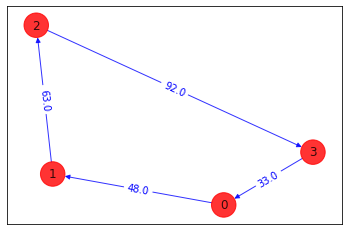

In [13]:
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [15]:
#IBMQ.get_provider(hub='ibm_q')

In [18]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("qasm_simulator")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

energy: -48489.29199218752
time: 713.9346680641174
feasible: True
solution: [3, 1, 0, 2]
solution objective: 302.0


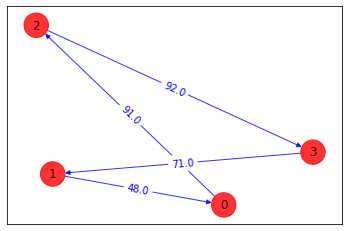

In [19]:
algorithm_globals.massive=True
spsa = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = VQE(ry, optimizer=spsa, quantum_instance=quantum_instance)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [20]:
algorithm_globals.random_seed = 123
seed = 10598
backend = Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend, seed_simulator=seed, seed_transpiler=seed)

optimal function value: 302.0
optimal value: [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
status: SUCCESS
solution: [3, 1, 0, 2]
solution objective: 302.0


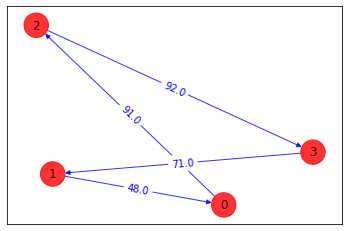

In [21]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result)

z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [22]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

MissingOptionalLibraryError: "The 'ipywidgets' library is required to use 'jupyter magics'. You can install it with 'pip install ipywidgets'."